In [1]:
import json
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from collections import Counter

%load_ext autoreload
%autoreload 2

# Change the working directory to the root of the GitHub repository
notebook_dir = os.getcwd()
if "ranking" in notebook_dir:
    os.chdir(os.path.dirname(os.path.abspath(notebook_dir)))
    print(f"Changed working directory to: {os.getcwd()}")

# Load JSONL files
def load_jsonl(file_path):
    with open(file_path, 'r') as file:
        return [json.loads(line) for line in file]

# File paths
train_file_path = 'ranking_dataset/mistral-instruct-train-1262505.jsonl'
test_file_path = 'ranking_dataset/mistral-instruct-test-1262505.jsonl'

# Load data
train_data = load_jsonl(train_file_path)
test_data = load_jsonl(test_file_path)

# Prepare train, validation, and test splits
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")
# Display all the keys in the dataset
print("Keys in data:", train_data[0].keys())
print("keys in candidates:", train_data[0]['candidates'][0].keys())

print("Keys in data:", test_data[0].keys())
print("keys in candidates:", test_data[0]['candidates'][0].keys())

### change a key.
# Update the key 'input' to 'input_token' in test_data
for entry in test_data:
    if 'input' in entry:
        entry['input_token'] = entry.pop('input')


Changed working directory to: /home/bowenson/Github/CoT-Rec
Training data size: 1593
Validation data size: 399
Test data size: 1319
Keys in data: dict_keys(['candidates', 'input_token', 'attention_mask', 'answer_scores', 'answer', 'is_correct'])
keys in candidates: dict_keys(['text', 'answer', 'answer_span', 'score', 'output_tokens'])
Keys in data: dict_keys(['candidates', 'input_token', 'attention_mask', 'answer_scores', 'answer', 'is_correct'])
keys in candidates: dict_keys(['text', 'answer', 'answer_span', 'score', 'output_tokens'])


In [2]:
def format_dataset(data):
    formatted_dataset = {
        "input_tokens": [],
        "output_tokens": [],
        "scores": []
    }
    for entry in data:
        input_tokens = entry['input_token']
        candidates = entry['candidates']
        answer = entry['answer']

        output_tokens_list = [candidate['output_tokens']+[candidate['score']] for candidate in candidates]
        scores_list = [1 if candidate['answer'] == answer else 0 for candidate in candidates]

        formatted_dataset["input_tokens"].append(input_tokens)
        formatted_dataset["output_tokens"].append(output_tokens_list)
        formatted_dataset["scores"].append(scores_list)

    return pd.DataFrame(formatted_dataset)

df_train = format_dataset(train_data)
df_validation = format_dataset(val_data)
df_test = format_dataset(test_data)

In [ ]:
# Example output
print(f"Example formatted dataset entry: {df_train.iloc[0]}")   
print(f"Total formatted dataset size: {len(df_train)}")

print(df_train['scores'].tolist())
print([df_train['output_tokens'][0][0][-1] for i in range(len(df_train['output_tokens'][0]))])

Example formatted dataset entry: input_tokens     [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
output_tokens    [[28705, 28770, 28734, 28734, 13, 13, 28824, 2...
scores           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
Name: 0, dtype: object
Total formatted dataset size: 5856
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [3]:
from ranking.xgboost_ranker import XGBoostRanker,RankingMetrics

# Initialize the XGBoost ranker
ranker = XGBoostRanker(objective='rank:map',eval_metric='map@1')
# Train the model
ranker.train(
    df_train['input_tokens'].tolist(),
    df_train['output_tokens'].tolist(),
    df_train['scores'].tolist(),
    (df_validation['input_tokens'].tolist(),
    df_validation['output_tokens'].tolist(),
    df_validation['scores'].tolist())
)
# Evaluate the model
predictions = ranker.predict(
    df_test['input_tokens'].tolist(),
    df_test['output_tokens'].tolist()
)

true_scores_flat = [score for group in df_test['scores'] for score in group]
predictions_flat = [pred for group in predictions for pred in group]
metrics = RankingMetrics.calculate_metrics(true_scores_flat, predictions_flat)

print("Metrics:", metrics)
acc = [entry['candidates'][np.argmax(pred)]['answer'] == entry['answer'] for pred, entry in zip(predictions, test_data)]
print("Accuracy:", np.mean(acc))

Using CPU for training.
[0]	validation-map@1:0.50627
[1]	validation-map@1:0.49875
[2]	validation-map@1:0.47619
[3]	validation-map@1:0.50877
[4]	validation-map@1:0.50877
[5]	validation-map@1:0.49123
[6]	validation-map@1:0.49123
[7]	validation-map@1:0.49875
[8]	validation-map@1:0.48622
[9]	validation-map@1:0.49624
[10]	validation-map@1:0.50627
[11]	validation-map@1:0.49624
[12]	validation-map@1:0.48622
[13]	validation-map@1:0.50376
[14]	validation-map@1:0.50125
[15]	validation-map@1:0.50627
[16]	validation-map@1:0.50877
[17]	validation-map@1:0.52130
[18]	validation-map@1:0.51128
[19]	validation-map@1:0.51880
[20]	validation-map@1:0.50125
[21]	validation-map@1:0.49373
[22]	validation-map@1:0.50627
[23]	validation-map@1:0.49123
[24]	validation-map@1:0.50376
[25]	validation-map@1:0.53634
[26]	validation-map@1:0.52130
[27]	validation-map@1:0.52130
[28]	validation-map@1:0.51378
[29]	validation-map@1:0.52632
[30]	validation-map@1:0.51629
[31]	validation-map@1:0.51128
[32]	validation-map@1:0.51

In [ ]:
# param_grid = {
#     "eta": [0.01, 0.1],
#     "max_depth": [3, 6, 10],
#     "min_child_weight": [1, 3],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0],
#     "lambda": [1, 5],
#     "alpha": [0, 1],
#     "objective": ["rank:pairwise", "rank:map"],
#     "eval_metric": ["map@1"]
# }



# ranker = XGBoostRanker()
# ranker,_ = ranker.hyperparameter_search(
#         (df_train['input_tokens'].tolist(),
#     df_train['output_tokens'].tolist(),
#     df_train['scores'].tolist())
#     , (df_validation['input_tokens'].tolist(),
#     df_validation['output_tokens'].tolist(),
#     df_validation['scores'].tolist())
#     , param_grid)

   top_k  max_prob  max_vote  max_probsum  top_recomm
0      1  0.487491  0.487491     0.487491    0.487491
1      5  0.605004  0.695224     0.718726    0.550417
2     10  0.586808  0.789992     0.796816    0.535254
3     20  0.554208  0.846096     0.865807    0.532980
4     30  0.530705  0.882487     0.904473    0.520849
5     40  0.505686  0.926459     0.943897    0.530705
6     50  0.498105  0.958302     1.000000    0.534496


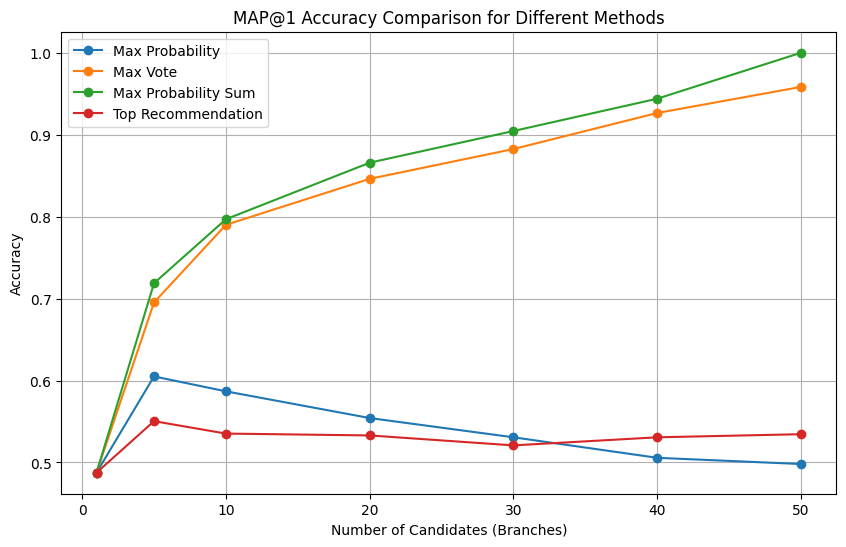

In [4]:
from cot_dataset.cot_decoding.task import GSMTask
import pandas as pd

task = GSMTask(encode_format='instruct')



results = []

for top_k in [1, 5, 10, 20, 30, 40, 50]:
    max_prob = []
    max_vote = []
    max_probsum = []
    top_recomm = []

    predictions = ranker.predict(
        df_test['input_tokens'].tolist(),
        [entry[:top_k] for entry in df_test['output_tokens']],
    )

    for entry, pred in zip(test_data, predictions):
        scores = []
        for can in entry['candidates'][:top_k]:
            scores.append((can['answer'], can['score']))
        max_prob.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])

        # Count the occurrences of each answer, if there is a tie, take the one with the highest score
        votes = Counter([can['answer'] for can in entry['candidates'][:top_k]])
        most_common_vote = votes.most_common(1)[0]
        if most_common_vote[1] == 1:
            max_vote.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])
        else:
            max_vote.append(most_common_vote[0] == entry['answer'])

        # Sum the scores for each answer
        score_sums = {}
        for can in entry['candidates'][:top_k]:
            score_sums[can['answer']] = score_sums.get(can['answer'], 0) + can['score']
        max_probsum.append(max(score_sums, key=score_sums.get) == entry['answer'])

        top_recomm.append(entry['candidates'][np.argmax(pred[:top_k])]['answer'] == entry['answer'])

    results.append({
        "top_k": top_k,
        "max_prob": sum(max_prob) / len(max_prob),
        "max_vote": sum(max_vote) / len(max_vote),
        "max_probsum": sum(max_probsum) / len(max_probsum),
        "top_recomm": sum(top_recomm) / len(top_recomm),
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['top_k'], results_df['max_prob'], label='Max Probability', marker='o')
plt.plot(results_df['top_k'], results_df['max_vote'], label='Max Vote', marker='o')
plt.plot(results_df['top_k'], results_df['max_probsum'], label='Max Probability Sum', marker='o')
plt.plot(results_df['top_k'], results_df['top_recomm'], label='Top Recommendation', marker='o')

plt.xlabel('Number of Candidates (Branches)')
plt.ylabel('Accuracy')
plt.title('MAP@1 Accuracy Comparison for Different Methods')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# train_data = load_jsonl(train_file_path)
# test_data = load_jsonl(test_file_path)

# # Prepare train, validation, and test splits
# train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
# ### change a key.
# Update the key 'input' to 'input_token' in test_data
for entry in test_data:
    if 'input' in entry:
        entry['input_token'] = entry.pop('input')
# second set of dataset
def format_dataset(data):
    formatted_dataset = {
        "input_tokens": [],
        "output_tokens": [],
        "scores": []
    }
    for entry in data:
        input_tokens = entry['input_token']
        candidates = entry['candidates']
        answer = entry['answer']

        # print("input_tokens:", input_tokens)
        # print("candidates:", candidates[0]['output_tokens'])
        # print("answer:", answer)

        output_tokens_list = [candidate['output_tokens']+[candidate['score']]+[candidate['answer']] for candidate in candidates]
        scores_list = [1 if candidate['answer'] == answer else 0 for candidate in candidates]

        formatted_dataset["input_tokens"].append(input_tokens)
        formatted_dataset["output_tokens"].append(output_tokens_list)
        formatted_dataset["scores"].append(scores_list)
        # break


    return pd.DataFrame(formatted_dataset)

df_train = format_dataset(train_data)
df_validation = format_dataset(val_data)
df_test = format_dataset(test_data)

# Example output
print(f"Example formatted dataset entry: {df_train.iloc[0]}")
print(f"Total formatted dataset size: {len(df_train)}")

print(df_train['scores'].tolist())
print([_d[0][-1] for _d in df_test['output_tokens']])


In [ ]:
# answer_counts = []
# for entry in df_train['output_tokens']:
#     answer_counts.append(Counter([candidate[-1] for candidate in entry]))

#     # Remove invalid results from the answer_counts
#     for i in range(len(answer_counts)):
#         if '[invalid]' in answer_counts[i]:
#             del answer_counts[i]['[invalid]']
# print(answer_counts[0])

df_test_copy = df_test.copy()
print([_d[-1] for _d in df_test_copy['output_tokens'][0]])

for i in range(len(df_test_copy['output_tokens'])):
    answer_counts = Counter([candidate[-1] for candidate in entry])
    for j in range(len(df_test_copy['output_tokens'][i])):
        # print(df_test_copy['output_tokens'][i][j][-1],answer_counts)

        df_test_copy['output_tokens'][i][j][-1] = answer_counts.get(df_test['output_tokens'][i][j][-1], 0)
#     break


for can in df_test_copy['output_tokens'][0]:
    print(can[-1])

In [ ]:
from ranking.xgboost_ranker import XGBoostRanker,RankingMetrics

# Initialize the XGBoost ranker
ranker = XGBoostRanker(objective='rank:map',eval_metric='map@1')
# Train the model
ranker.train(
    df_train['input_tokens'].tolist(),
    df_train['output_tokens'].tolist(),
    df_train['scores'].tolist(),
    (df_validation['input_tokens'].tolist(),
    df_validation['output_tokens'].tolist(),
    df_validation['scores'].tolist())
)
# Evaluate the model
predictions = ranker.predict(
    df_test['input_tokens'].tolist(),
    df_test['output_tokens'].tolist()
)

true_scores_flat = [score for group in df_test['scores'] for score in group]
predictions_flat = [pred for group in predictions for pred in group]
metrics = RankingMetrics.calculate_metrics(true_scores_flat, predictions_flat)

print("Metrics:", metrics)
acc = [entry['candidates'][np.argmax(pred)]['answer'] == entry['answer'] for pred, entry in zip(predictions, test_data)]
print("Accuracy:", np.mean(acc))

from cot_dataset.cot_decoding.task import GSMTask
from collections import Counter
import pandas as pd

task = GSMTask(encode_format='qa')



results = []

for top_k in [1, 5, 10, 20, 30, 40, 50]:
    max_prob = []
    max_vote = []
    max_probsum = []
    top_recomm = []
    correct_included = []

    predictions = ranker.predict(
        df_test['input_tokens'].tolist(),
        [entry[:top_k] for entry in df_test['output_tokens']],
    )

    for entry, pred in zip(test_data, predictions):
        scores = []
        for can in entry['candidates'][:top_k]:
            scores.append((can['answer'], can['score']))
        max_prob.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])

        correct_included.append(
            any([can['answer'] == entry['answer'] for can in entry['candidates'][:top_k]])
        )

        # Count the occurrences of each answer, if there is a tie, take the one with the highest score
        votes = Counter([can['answer'] for can in entry['candidates'][:top_k]])
        most_common_vote = votes.most_common(1)[0]
        if most_common_vote[1] == 1:
            max_vote.append(sorted(scores, key=lambda x: x[1], reverse=True)[0][0] == entry['answer'])
        else:
            max_vote.append(most_common_vote[0] == entry['answer'])

        # Sum the scores for each answer
        score_sums = {}
        for can in entry['candidates'][:top_k]:
            score_sums[can['answer']] = score_sums.get(can['answer'], 0) + can['score']
        max_probsum.append(max(score_sums, key=score_sums.get) == entry['answer'])

        top_recomm.append(entry['candidates'][np.argmax(pred[:top_k])]['answer'] == entry['answer'])

    results.append({
        "top_k": top_k,
        "max_prob": sum(max_prob) / len(max_prob),
        "max_vote": sum(max_vote) / len(max_vote),
        "max_probsum": sum(max_probsum) / len(max_probsum),
        "top_recomm": sum(top_recomm) / len(top_recomm),
        "correct_included": sum(correct_included) / len(correct_included),
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['top_k'], results_df['max_prob'], label='Max Probability', marker='o')
plt.plot(results_df['top_k'], results_df['max_vote'], label='Max Vote', marker='o')
plt.plot(results_df['top_k'], results_df['max_probsum'], label='Max Probability Sum', marker='o')
plt.plot(results_df['top_k'], results_df['top_recomm'], label='Top Recommendation', marker='o')
plt.plot(results_df['top_k'], results_df['correct_included'], label='Correct Included', marker='o')

plt.xlabel('Number of Candidates (Branches)')
plt.ylabel('Accuracy')
plt.title('MAP@1 Accuracy Comparison for Different Methods')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# ranking head
from ranking.ranking_head_ranker import Ranker, data_from_file

df_train, df_validation, df_test = data_from_file(\
    'ranking_dataset/mistral-base-train-1108935.jsonl',\
            'ranking_dataset/mistral-base-test-1096727.jsonl')

print("Training data shape:", df_train.shape)
print("Validation data shape:", df_validation.shape)
print("Test data shape:", df_test.shape)



Training data shape: (5856, 3)
Validation data shape: (1464, 3)
Test data shape: (1319, 3)


In [ ]:
ranker = Ranker()

# Train
ranker.train(
    df_train['input_tokens'].tolist(),
    df_train['output_tokens'].tolist(),
    df_train['scores'].tolist(),
    epochs=1,
    batch_size=528,
)

# Predict
scores = ranker.predict(
    df_test['input_tokens'].tolist(),
    df_test['output_tokens'].tolist(),
)

print(np.array(scores).shape)

print("Scores:", scores)
# Evaluate MAP@1
map1 = ranker.evaluate_map1(
    df_test['input_tokens'].tolist(),
    df_test['output_tokens'].tolist(),
    df_test['scores'].tolist()
)
print("MAP@1:", map1)
# Save the model
ranker.model.save_pretrained('ranking_model_head')
ranker.tokenizer.save_pretrained('ranking_model_head_tokenizer')
print("Model saved to 'ranking_model' directory.")